Model: DecisionTree
Cross-validation mean accuracy: 0.9872
Training set accuracy: 1.0000
Validation set accuracy: 0.9889
Training set error: 0.0000
Validation set error: 0.0111



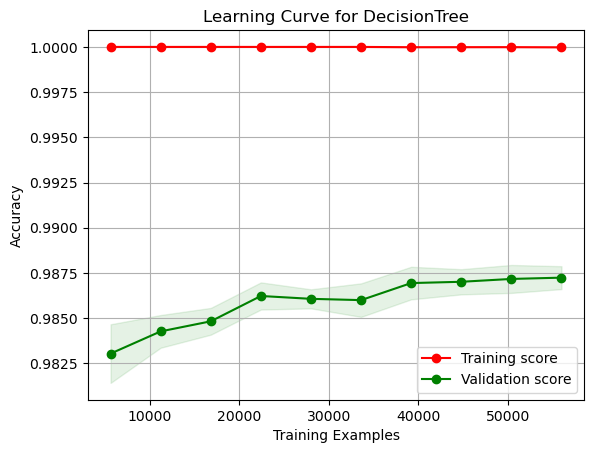

Model: XGBoost
Cross-validation mean accuracy: 0.9895
Training set accuracy: 0.9983
Validation set accuracy: 0.9900
Training set error: 0.0017
Validation set error: 0.0100



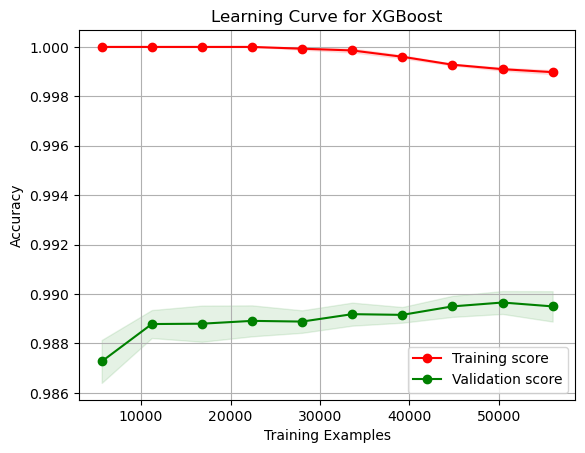

In [2]:
# Preprocessing, Cross-validate

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load datasets
df_train = pd.read_csv('panic_disorder_dataset_training.csv')
df_test = pd.read_csv('panic_disorder_dataset_testing.csv')

# Drop Participant ID from training and test data
df_train = df_train.drop(columns=['Participant ID'])
df_test = df_test.drop(columns=['Participant ID'])

# Features and target
X = df_train.drop(columns=['Panic Disorder Diagnosis'])
y = df_train['Panic Disorder Diagnosis']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Impute missing values
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='mean')

# Apply imputation
X_train[categorical_features] = imputer_cat.fit_transform(X_train[categorical_features])
X_val[categorical_features] = imputer_cat.transform(X_val[categorical_features])
X_train[numerical_features] = imputer_num.fit_transform(X_train[numerical_features])
X_val[numerical_features] = imputer_num.transform(X_val[numerical_features])

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    label_encoders[col] = le

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # Keep the rest of the features as they are
)

# Define models
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation and learning curve plotting
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validate models
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # Fit the model on the training set and evaluate on the validation set
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    val_score = pipeline.score(X_val, y_val)
    
    # Calculate training and validation errors
    train_error = 1 - train_score
    val_error = 1 - val_score
    
    # Print model performance
    print(f"Model: {model_name}")
    print(f"Cross-validation mean accuracy: {cv_results.mean():.4f}")
    print(f"Training set accuracy: {train_score:.4f}")
    print(f"Validation set accuracy: {val_score:.4f}")
    print(f"Training set error: {train_error:.4f}")
    print(f"Validation set error: {val_error:.4f}\n")
    
    # Plot learning curve
    train_sizes, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure()
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label='Validation score')
    
    plt.legend(loc='best')
    plt.show()



Decision Tree Pruned Validation Accuracy: 0.9905
Decision Tree Pruned Training Accuracy: 0.9913
Decision Tree Pruned Training Error: 0.0087
Decision Tree Pruned Validation Error: 0.0095


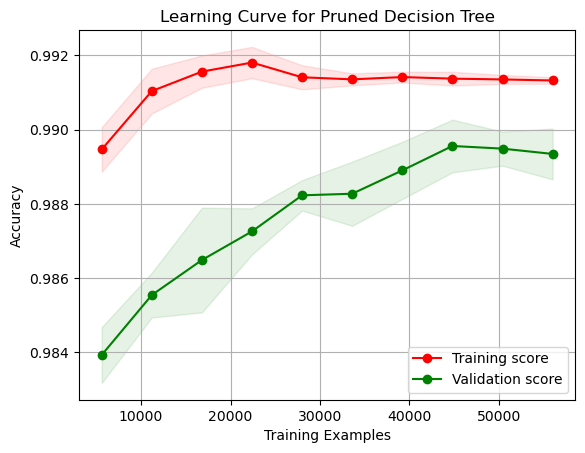

In [3]:
# Pruned Decision Tree model
dt_model_pruned = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20, min_samples_leaf=1)
pipeline_dt_pruned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model_pruned)
])
pipeline_dt_pruned.fit(X_train, y_train)
dt_pruned_val_score = pipeline_dt_pruned.score(X_val, y_val)
dt_pruned_train_score = pipeline_dt_pruned.score(X_train, y_train)
dt_pruned_train_error = 1 - dt_pruned_train_score
dt_pruned_val_error = 1 - dt_pruned_val_score

print(f"Decision Tree Pruned Validation Accuracy: {dt_pruned_val_score:.4f}")
print(f"Decision Tree Pruned Training Accuracy: {dt_pruned_train_score:.4f}")
print(f"Decision Tree Pruned Training Error: {dt_pruned_train_error:.4f}")
print(f"Decision Tree Pruned Validation Error: {dt_pruned_val_error:.4f}")

# Plot learning curve for the pruned Decision Tree model
train_sizes, train_scores, val_scores = learning_curve(pipeline_dt_pruned, X_train, y_train, cv=kfold, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure()
plt.title('Learning Curve for Pruned Decision Tree')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label='Validation score')

plt.legend(loc='best')
plt.show()


In [4]:
feature_importances = pipeline_dt_pruned.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                Feature  Importance
6              Severity    0.149163
2        Family History    0.133417
7        Impact on Life    0.123425
14    Lifestyle Factors    0.106426
4     Current Stressors    0.102138
12    Coping Mechanisms    0.089379
5              Symptoms    0.078925
3      Personal History    0.077417
13       Social Support    0.059117
9       Medical History    0.033844
8          Demographics    0.027667
10  Psychiatric History    0.008498
0                   Age    0.006033
11        Substance Use    0.004275
1                Gender    0.000277


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

dt_predictions = pipeline_dt_pruned.predict(X_val)
print("Decision Tree Classification Report:")
print(classification_report(y_val, dt_predictions))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_val, dt_predictions))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28715
           1       0.88      0.90      0.89      1285

    accuracy                           0.99     30000
   macro avg       0.94      0.95      0.94     30000
weighted avg       0.99      0.99      0.99     30000

Decision Tree Confusion Matrix:
[[28553   162]
 [  124  1161]]


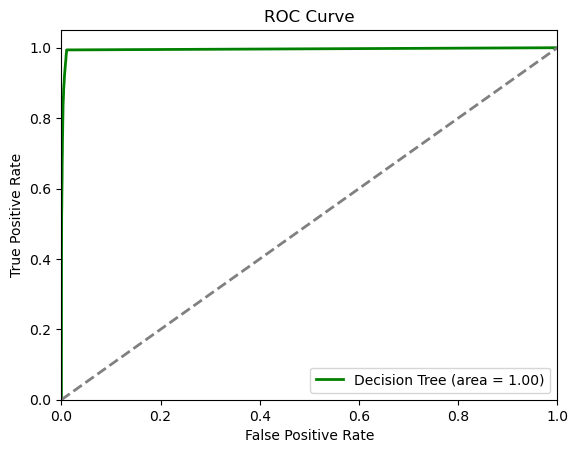

In [7]:
from sklearn.metrics import roc_curve, auc

# Decision Tree
dt_proba = pipeline_dt_pruned.predict_proba(X_val)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_val, dt_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Evaluating performance for feature: Age


C:\Users\rebec\AppData\Local\Temp\ipykernel_7956\1893923336.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))


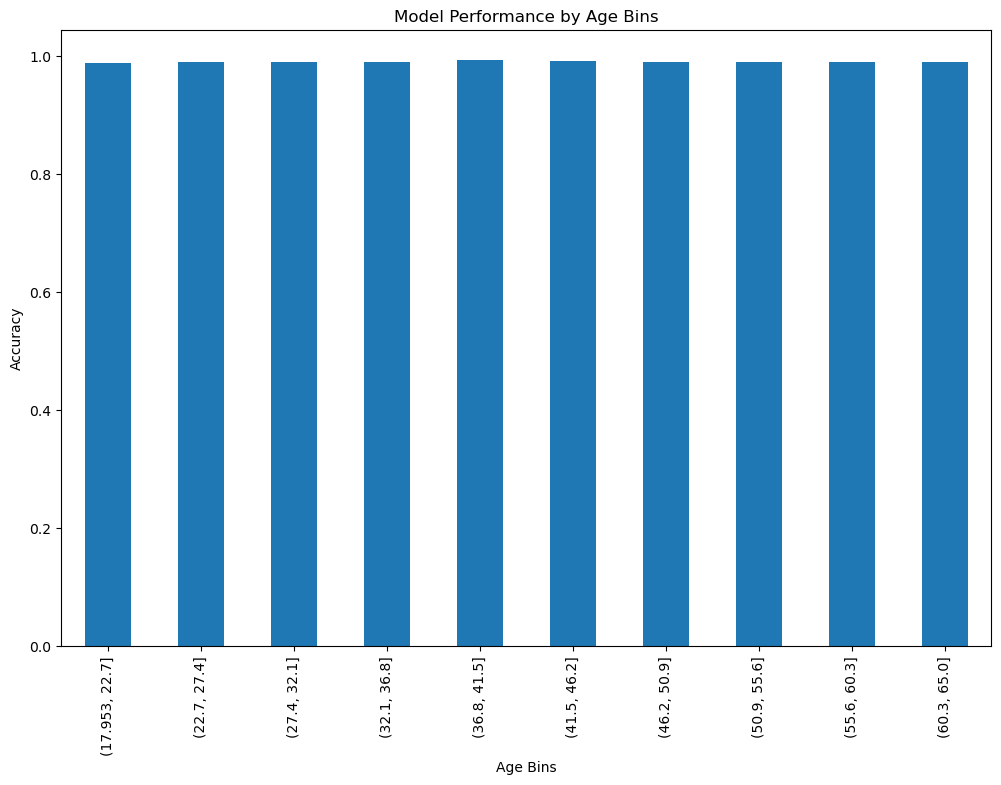

feature_bin
(17.953, 22.7]    0.988839
(22.7, 27.4]      0.989799
(27.4, 32.1]      0.990039
(32.1, 36.8]      0.990620
(36.8, 41.5]      0.993947
(41.5, 46.2]      0.991552
(46.2, 50.9]      0.989654
(50.9, 55.6]      0.990583
(55.6, 60.3]      0.990180
(60.3, 65.0]      0.989237
dtype: float64
Evaluating performance for feature: Gender


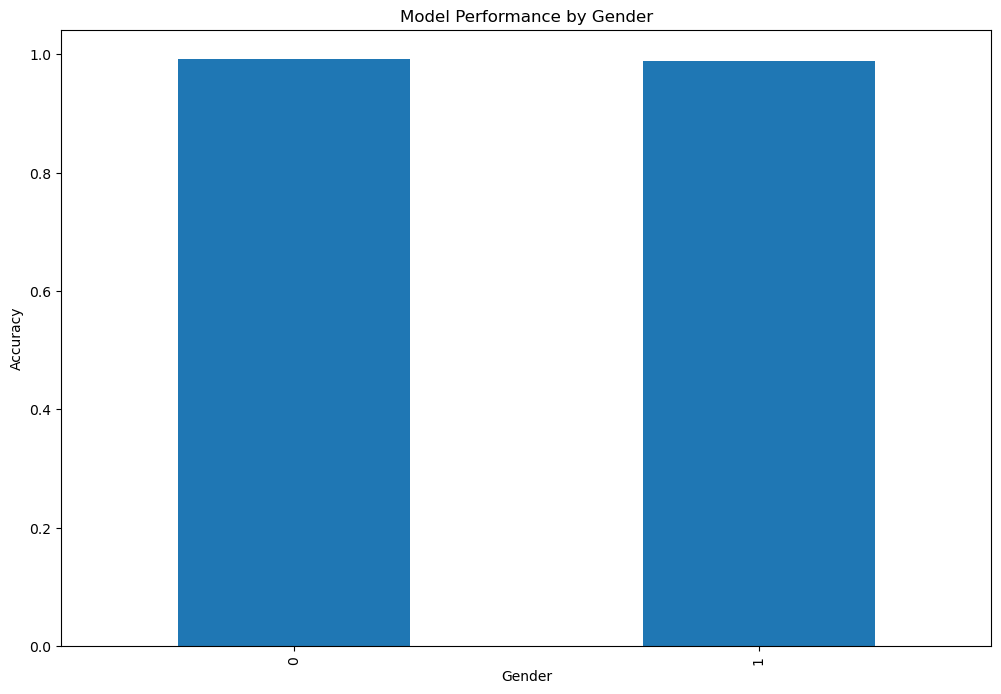

Gender
0    0.991859
1    0.989077
dtype: float64
Evaluating performance for feature: Family History


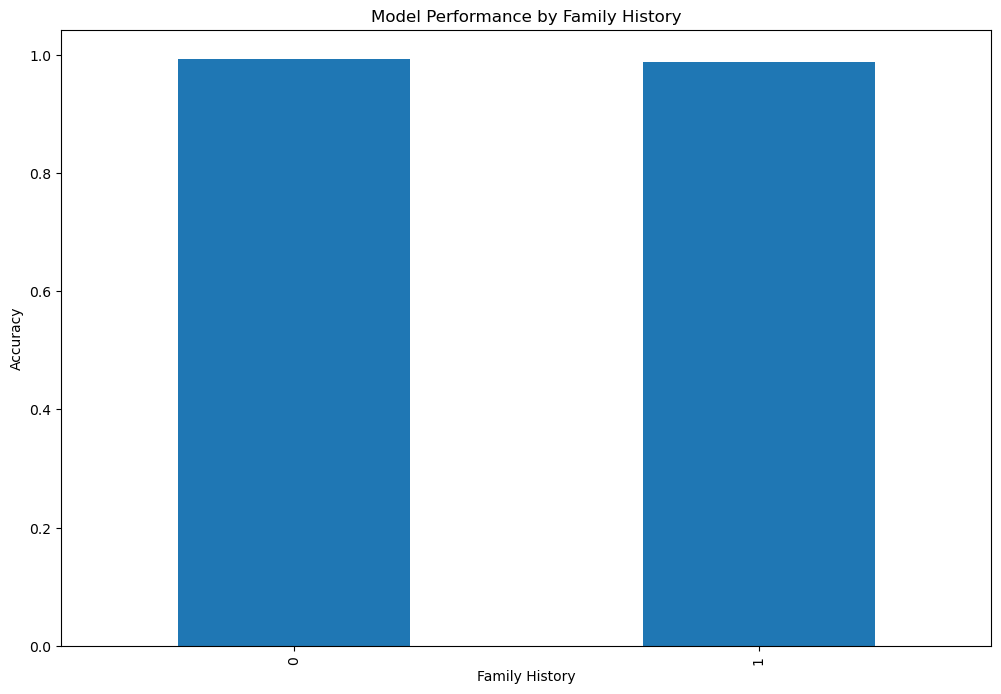

Family History
0    0.992467
1    0.988466
dtype: float64
Evaluating performance for feature: Personal History


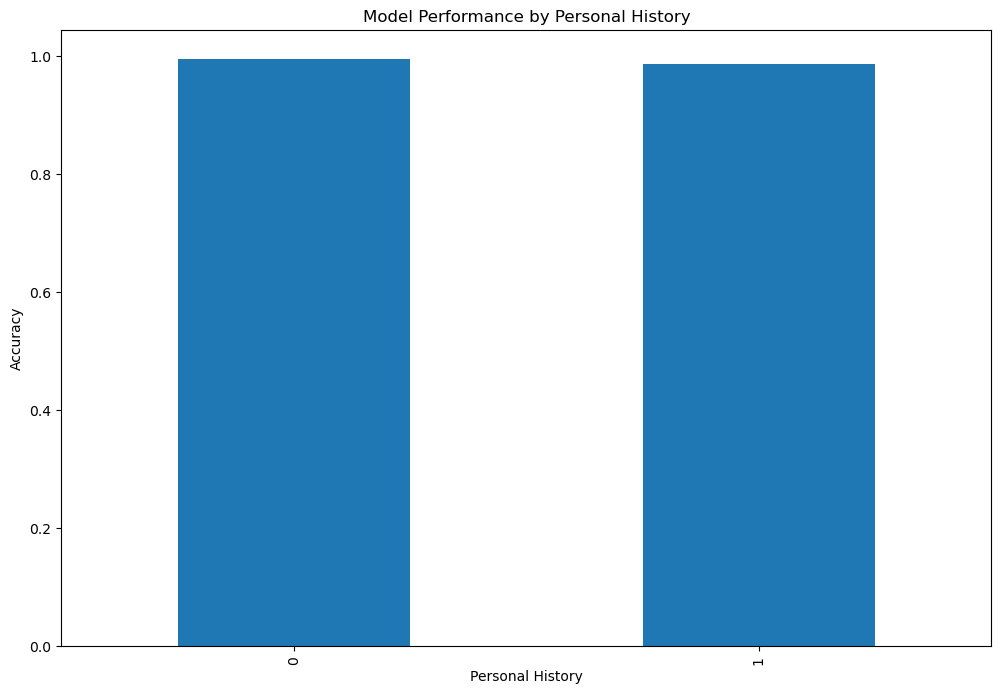

Personal History
0    0.994459
1    0.986387
dtype: float64
Evaluating performance for feature: Current Stressors


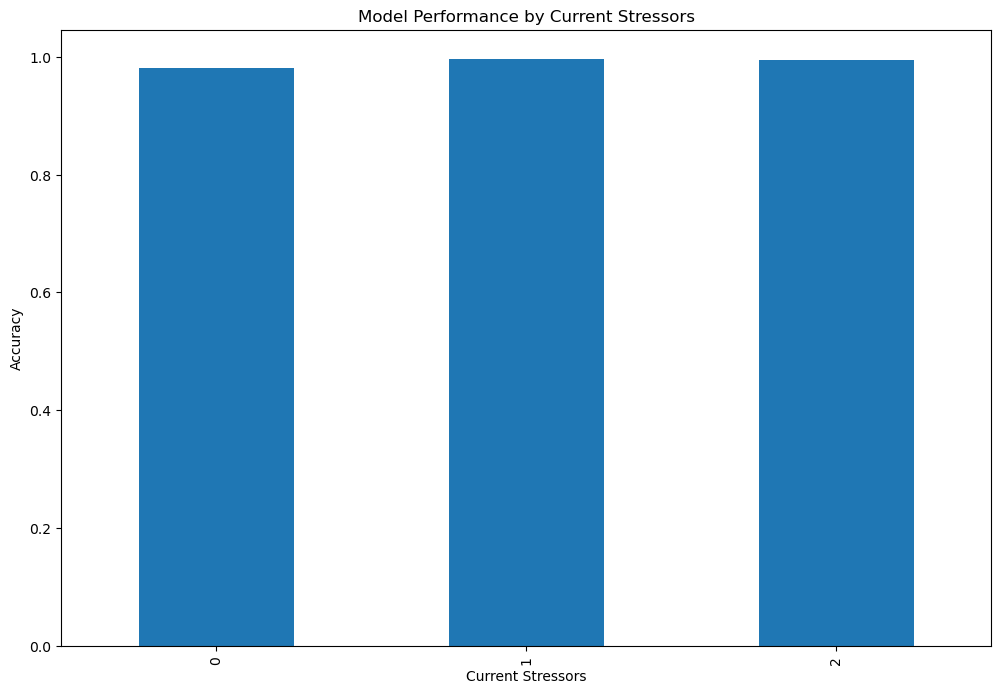

Current Stressors
0    0.980258
1    0.996021
2    0.995237
dtype: float64
Evaluating performance for feature: Symptoms


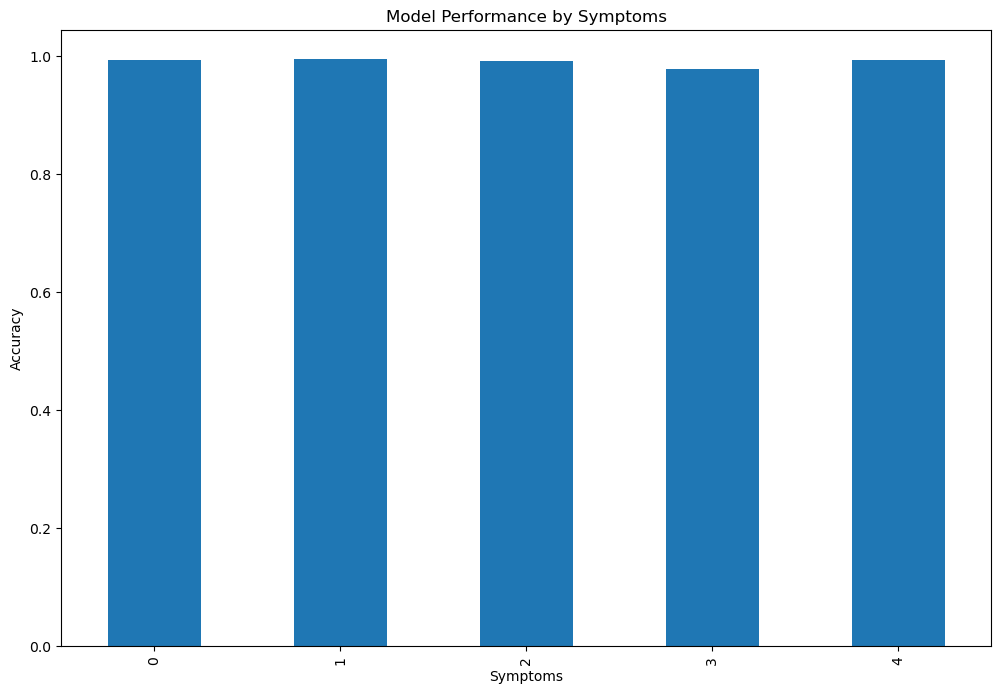

Symptoms
0    0.992962
1    0.995013
2    0.992175
3    0.978892
4    0.993121
dtype: float64
Evaluating performance for feature: Severity


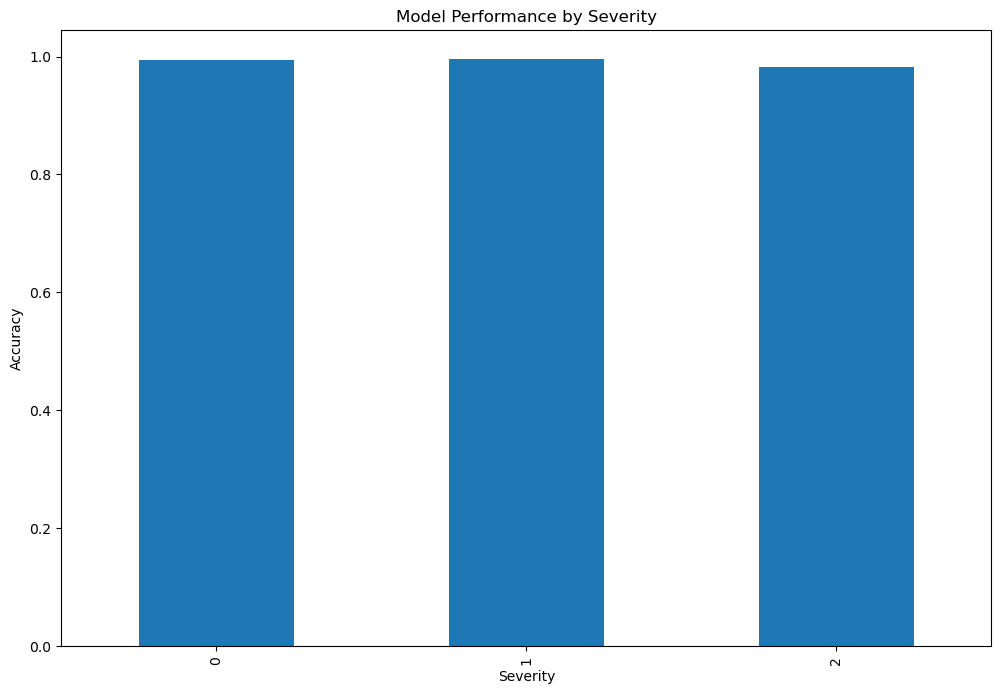

Severity
0    0.993684
1    0.995464
2    0.982383
dtype: float64
Evaluating performance for feature: Impact on Life


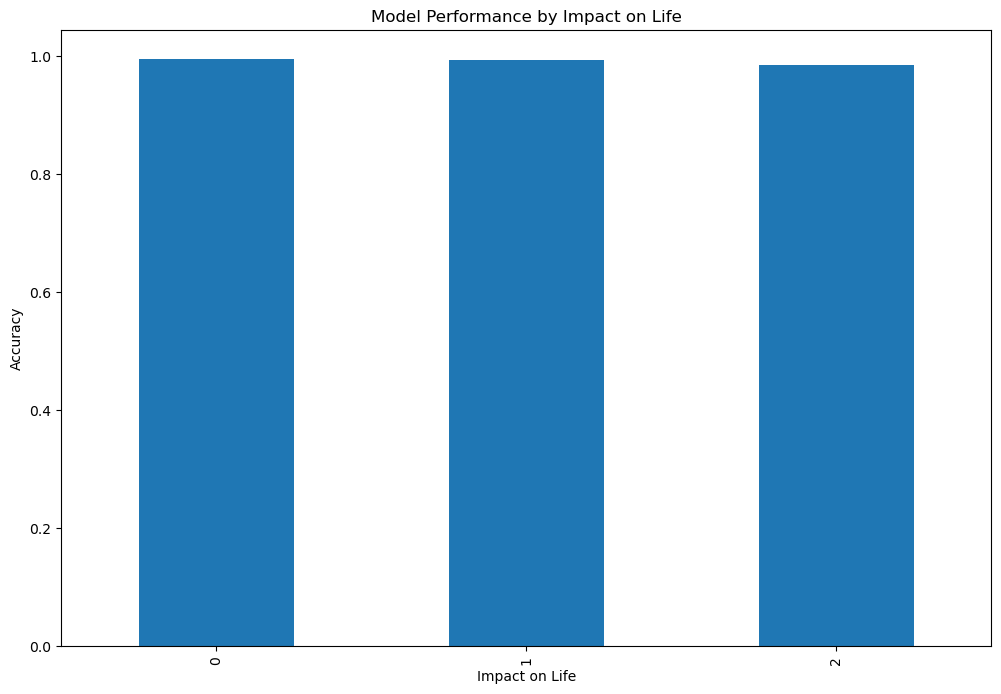

Impact on Life
0    0.994092
1    0.993411
2    0.983894
dtype: float64
Evaluating performance for feature: Demographics


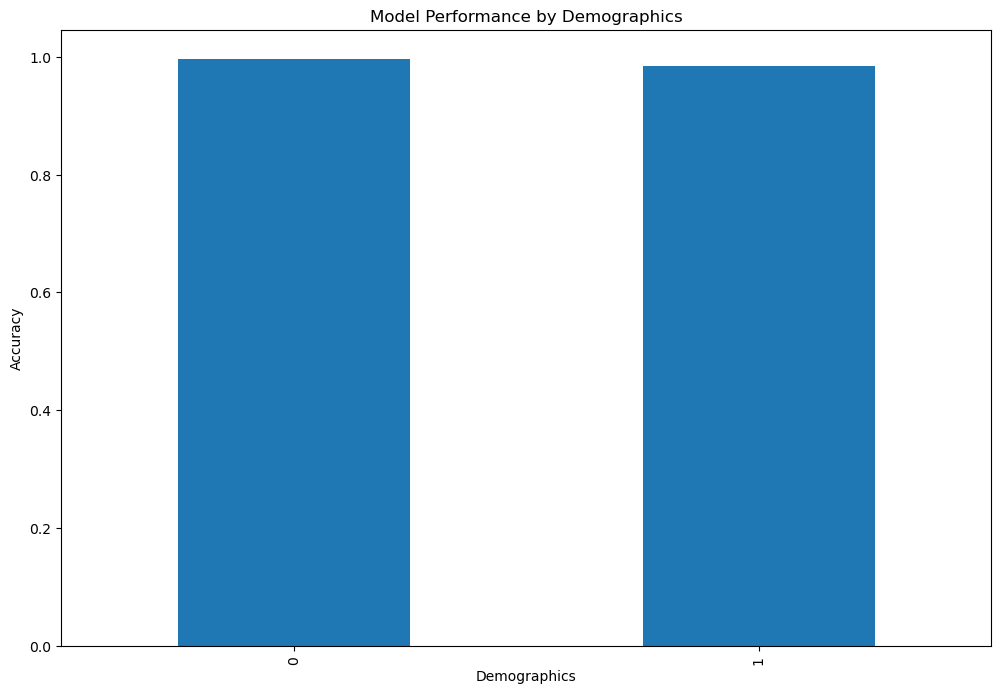

Demographics
0    0.996150
1    0.984734
dtype: float64
Evaluating performance for feature: Medical History


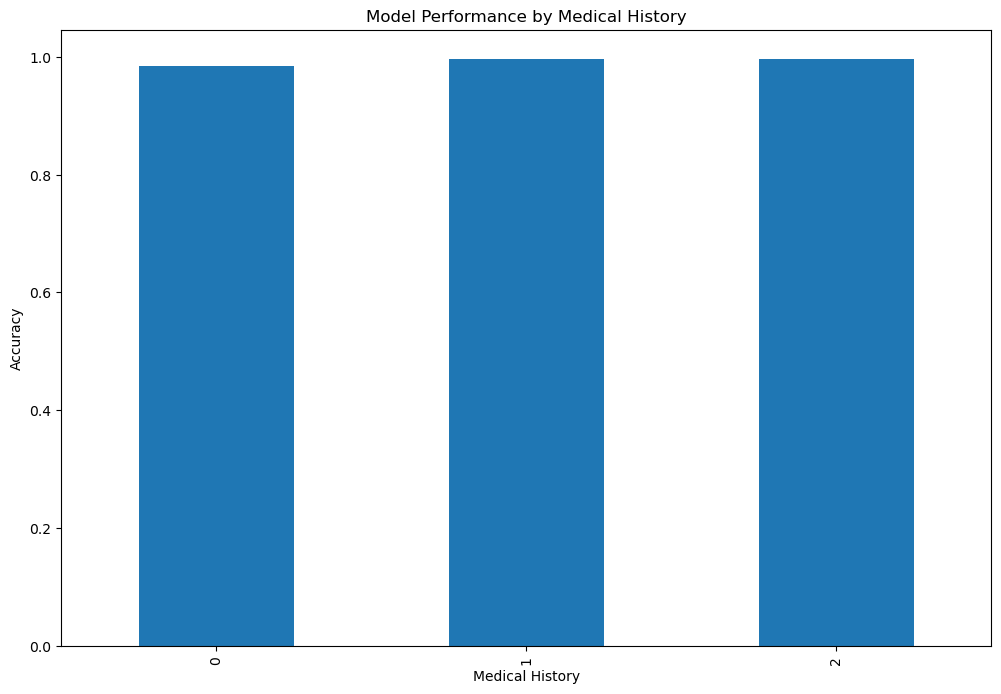

Medical History
0    0.984902
1    0.995892
2    0.995836
dtype: float64
Evaluating performance for feature: Psychiatric History


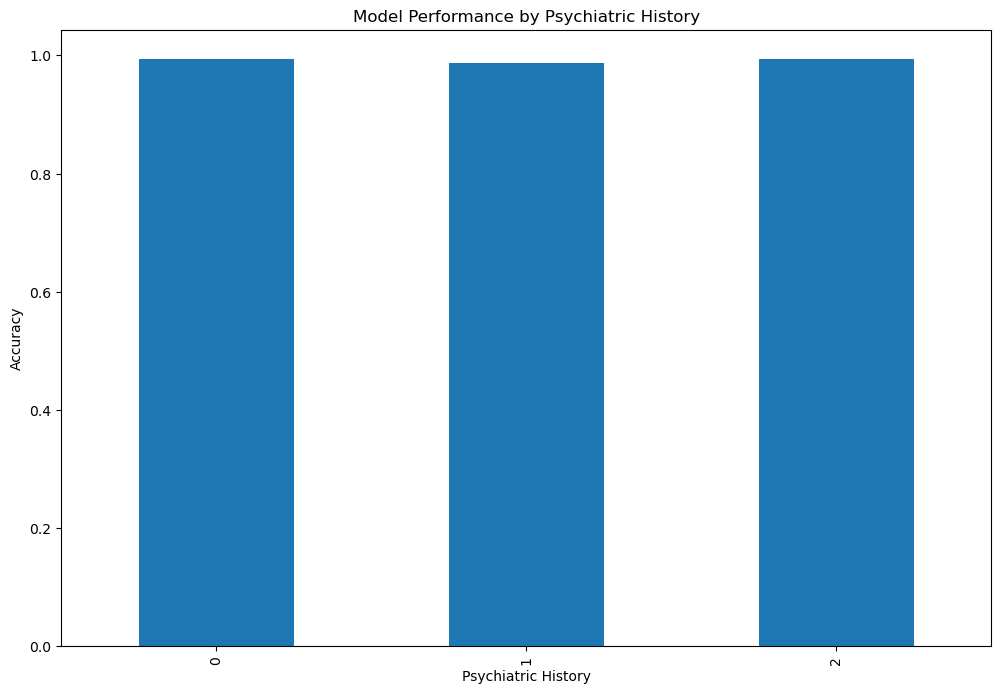

Psychiatric History
0    0.993372
1    0.987395
2    0.993701
dtype: float64
Evaluating performance for feature: Substance Use


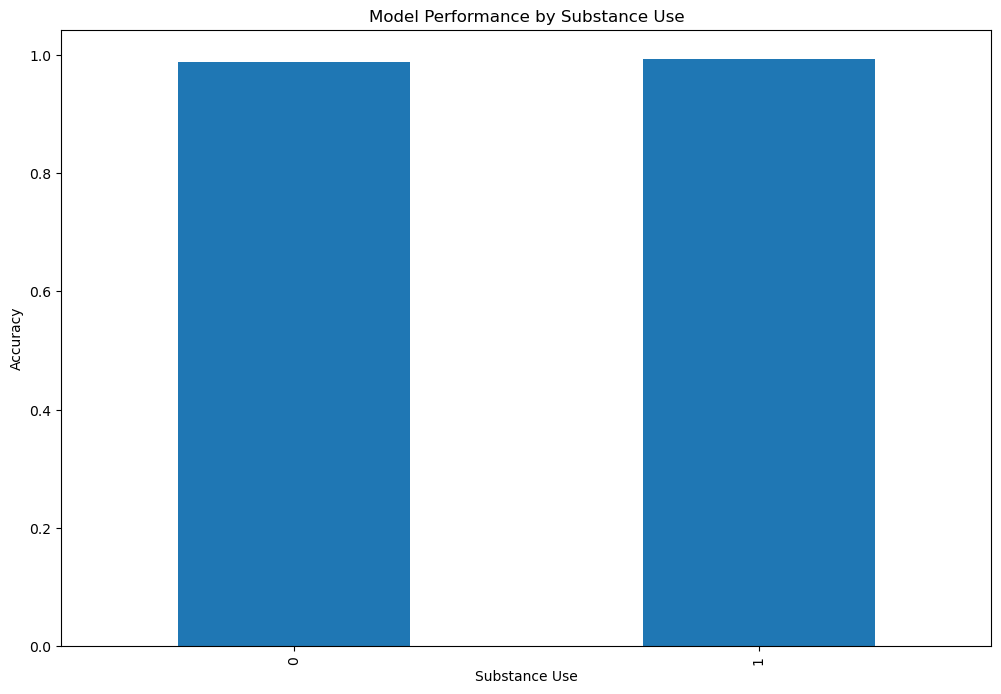

Substance Use
0    0.989148
1    0.993139
dtype: float64
Evaluating performance for feature: Coping Mechanisms


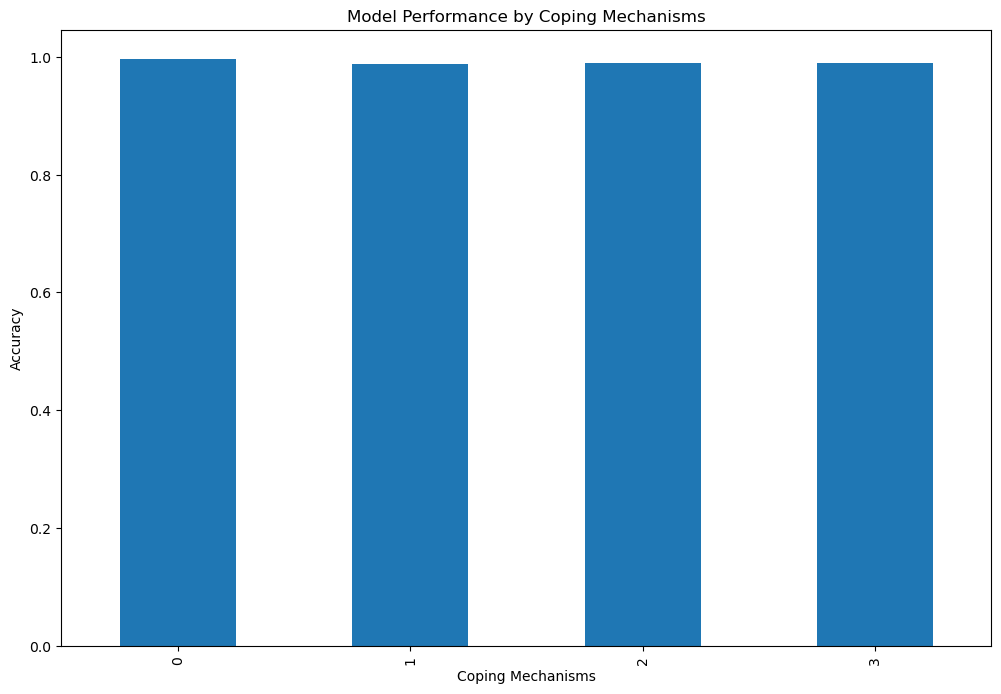

Coping Mechanisms
0    0.995947
1    0.987802
2    0.989323
3    0.988899
dtype: float64
Evaluating performance for feature: Social Support


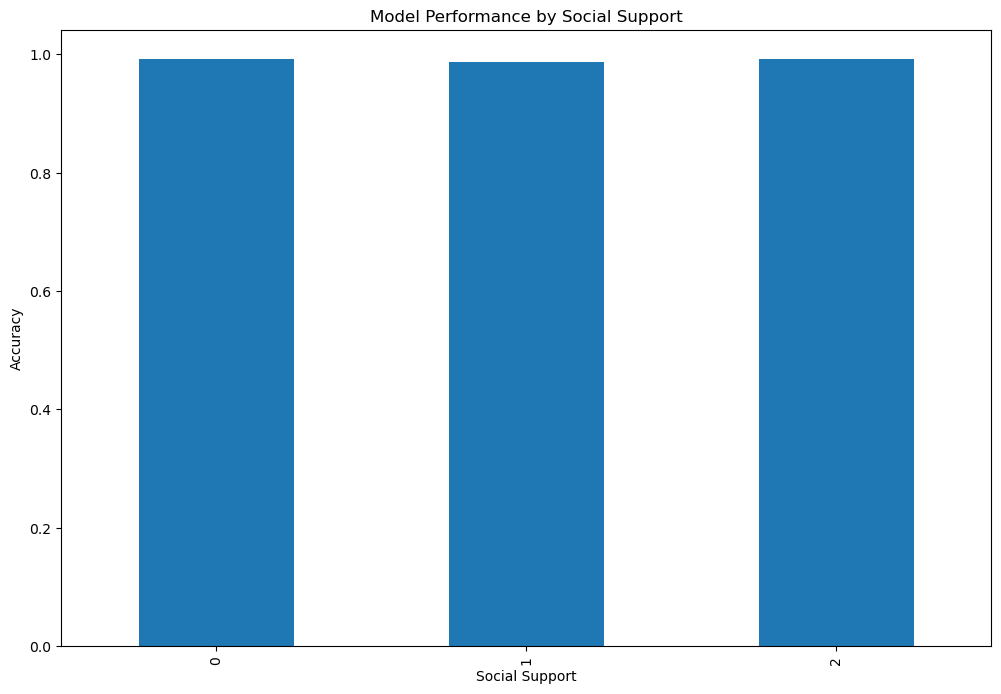

Social Support
0    0.991963
1    0.988006
2    0.991428
dtype: float64
Evaluating performance for feature: Lifestyle Factors


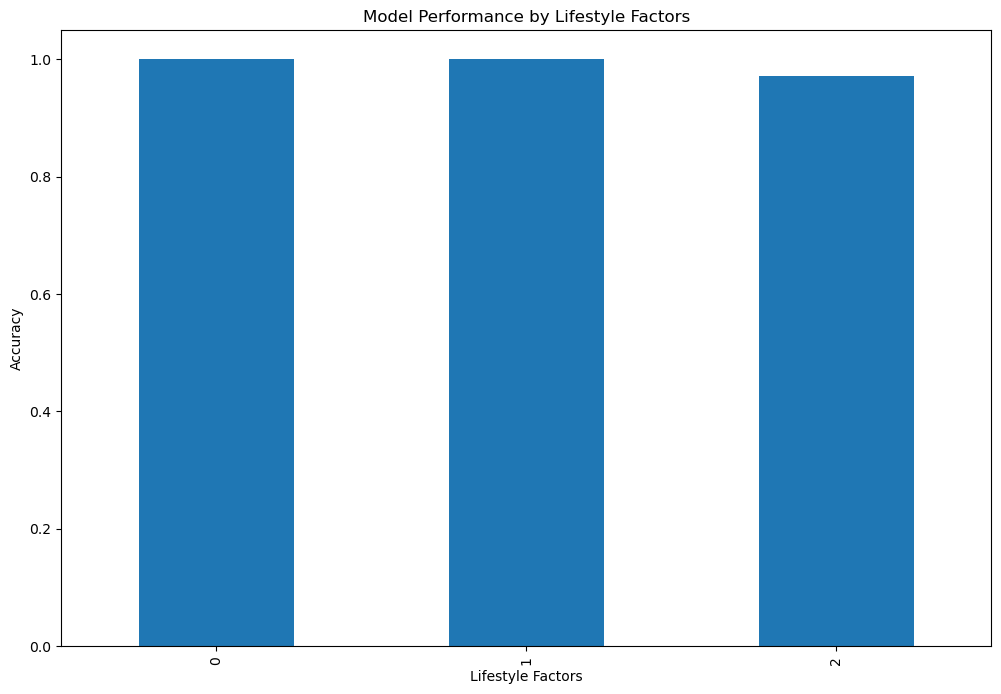

Lifestyle Factors
0    1.00000
1    1.00000
2    0.97142
dtype: float64


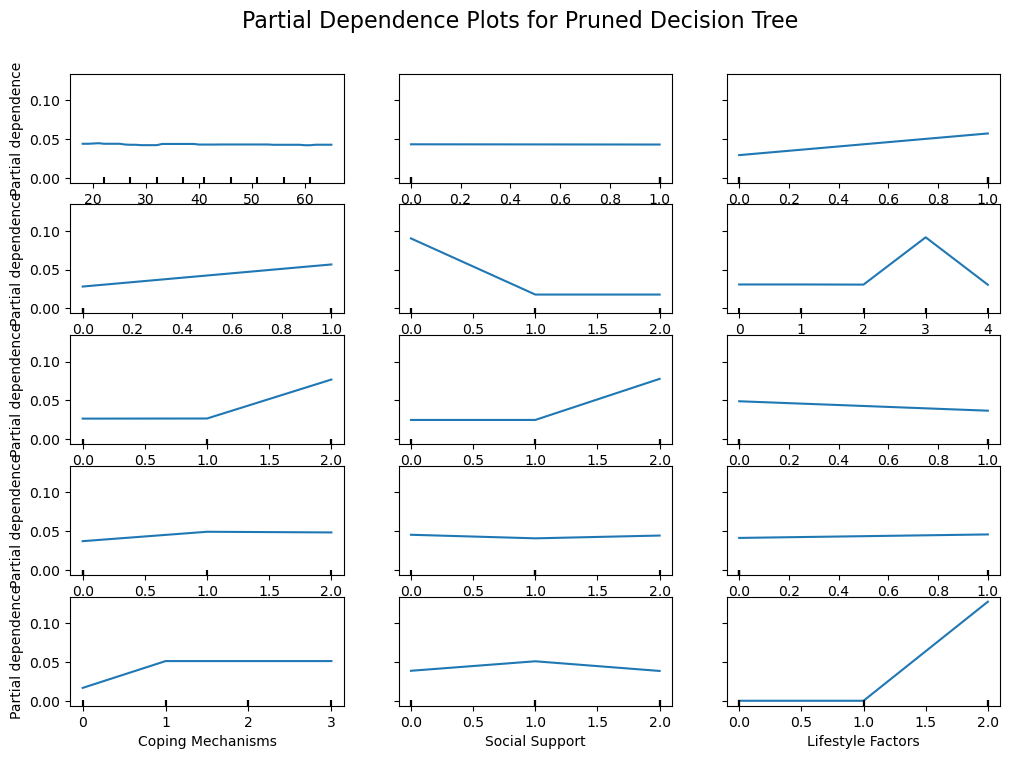

In [10]:
# Function to evaluate model performance for specific feature values
def evaluate_performance_by_feature(model, X, y, feature, is_categorical=False, bins=10):
    df = X.copy()
    df['target'] = y
    df['prediction'] = model.predict(X)
    
    if is_categorical:
        performance_by_bin = df.groupby(feature).apply(lambda group: accuracy_score(group['target'], group['prediction']))
    else:
        df['feature_bin'] = pd.cut(df[feature], bins=bins)
        performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))
    
    plt.figure(figsize=(12, 8))
    performance_by_bin.plot(kind='bar')
    plt.title(f'Model Performance by {feature}' + (' Bins' if not is_categorical else ''))
    plt.xlabel(f'{feature}' + (' Bins' if not is_categorical else ''))
    plt.ylabel('Accuracy')
    plt.show()
    
    return performance_by_bin

# Evaluate performance for numerical features for the pruned decision tree
for feature in numerical_features:
    print(f"Evaluating performance for feature: {feature}")
    performance_by_bin = evaluate_performance_by_feature(pipeline_dt_pruned, X_val, y_val, feature)
    print(performance_by_bin)

# Evaluate performance for categorical features for the pruned decision tree
for feature in categorical_features:
    print(f"Evaluating performance for feature: {feature}")
    performance_by_bin = evaluate_performance_by_feature(pipeline_dt_pruned, X_val, y_val, feature, is_categorical=True)
    print(performance_by_bin)

# Plot partial dependence plots for important features
features_to_plot = list(numerical_features) + list(categorical_features)  # Combine numerical and categorical features

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(pipeline_dt_pruned, X_train, features_to_plot, ax=ax, grid_resolution=50)
plt.subplots_adjust(top=0.9)
fig.suptitle('Partial Dependence Plots for Pruned Decision Tree', fontsize=16)
plt.show()

In [11]:

import pickle

# Save the pruned Decision Tree model to a pickle file
with open('dtc_model.pkl', 'wb') as file:
    pickle.dump(pipeline_dt_pruned, file)

In [13]:

for col in categorical_features:
    encoded_column = X_val[col]
    unique_encoded_values = np.unique(encoded_column)
    original_values = label_encoders[col].inverse_transform(unique_encoded_values)
    print(f"Unique encoded values for {col}: {unique_encoded_values}")
    print(f"Unique original values for {col}: {original_values}")

Unique encoded values for Gender: [0 1]
Unique original values for Gender: ['Female' 'Male']
Unique encoded values for Family History: [0 1]
Unique original values for Family History: ['No' 'Yes']
Unique encoded values for Personal History: [0 1]
Unique original values for Personal History: ['No' 'Yes']
Unique encoded values for Current Stressors: [0 1 2]
Unique original values for Current Stressors: ['High' 'Low' 'Moderate']
Unique encoded values for Symptoms: [0 1 2 3 4]
Unique original values for Symptoms: ['Chest pain' 'Dizziness' 'Fear of losing control' 'Panic attacks'
 'Shortness of breath']
Unique encoded values for Severity: [0 1 2]
Unique original values for Severity: ['Mild' 'Moderate' 'Severe']
Unique encoded values for Impact on Life: [0 1 2]
Unique original values for Impact on Life: ['Mild' 'Moderate' 'Significant']
Unique encoded values for Demographics: [0 1]
Unique original values for Demographics: ['Rural' 'Urban']
Unique encoded values for Medical History: [0 1 2]
U

In [14]:
# Preprocess the testing data
X_test = df_test.drop(columns=['Panic Disorder Diagnosis'])
y_test = df_test['Panic Disorder Diagnosis']

# Apply imputation
X_test[categorical_features] = imputer_cat.transform(X_test[categorical_features])
X_test[numerical_features] = imputer_num.transform(X_test[numerical_features])

# Apply label encoding
for col in categorical_features:
    X_test[col] = label_encoders[col].transform(X_test[col])

# Evaluate the pruned decision tree model on the testing data
dt_pruned_test_score = pipeline_dt_pruned.score(X_test, y_test)
dt_pruned_test_error = 1 - dt_pruned_test_score

print(f"Decision Tree Pruned Testing Accuracy: {dt_pruned_test_score:.4f}")
print(f"Decision Tree Pruned Testing Error: {dt_pruned_test_error:.4f}")


Decision Tree Pruned Testing Accuracy: 0.9907
Decision Tree Pruned Testing Error: 0.0093


In [15]:
pip install shap

In [7]:
# Function to evaluate model performance for specific feature values
def evaluate_performance_by_feature(model, X, y, feature, is_categorical=False, bins=10):
    df = X.copy()
    df['target'] = y
    df['prediction'] = model.predict(X)
    
    if is_categorical:
        performance_by_bin = df.groupby(feature).apply(lambda group: accuracy_score(group['target'], group['prediction']))
    else:
        df['feature_bin'] = pd.cut(df[feature], bins=bins)
        performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))
    
    plt.figure(figsize=(12, 8))
    performance_by_bin.plot(kind='bar')
    plt.title(f'Model Performance by {feature}' + (' Bins' if not is_categorical else ''))
    plt.xlabel(f'{feature}' + (' Bins' if not is_categorical else ''))
    plt.ylabel('Accuracy')
    plt.show()
    
    return performance_by_bin

# Evaluate performance for numerical features for the pruned decision tree
for feature in numerical_features:
    print(f"Evaluating performance for feature: {feature}")
    performance_by_bin = evaluate_performance_by_feature(pipeline_dt_pruned, X_val, y_val, feature)
    print(performance_by_bin)

# Evaluate performance for categorical features for the pruned decision tree
for feature in categorical_features:
    print(f"Evaluating performance for feature: {feature}")
    performance_by_bin = evaluate_performance_by_feature(pipeline_dt_pruned, X_val, y_val, feature, is_categorical=True)
    print(performance_by_bin)



Evaluating performance for feature: Age


C:\Users\rebec\AppData\Local\Temp\ipykernel_8908\857519842.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))


NameError: name 'accuracy_score' is not defined